In [1]:
import numpy as np
from utils import *
from classify_samples_MH import *
import joblib
import matplotlib.pyplot as plt
from scipy.stats import chi2
from performance_utils import *

## Read signals

In [2]:
error_not_distracted, u_signal_not_distracted, x_signal_not_distracted = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/u.csv', x_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRN/x.csv')
error_distracted, u_signal_distracted, x_signal_distracted         = process_signals(error_file= r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/e.csv', u_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/u.csv', x_file=r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/x.csv')

person_idx = 0
tc_test = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/mdist.csv', delimiter=',')
tc_test_col = tc_test[:, person_idx]

# combine the entire list in the priors
error_not_distracted_person = np.concatenate(error_not_distracted[person_idx])
u_not_distracted_person = np.concatenate(u_signal_not_distracted[person_idx])
x_not_distracted_person = np.concatenate(x_signal_not_distracted[person_idx])

# X_not_distracted = np.column_stack((error_not_distracted_person[:-1], u_not_distracted_person[:-1], x_not_distracted_person[:-1]))

X_not_distracted = np.column_stack((error_not_distracted_person, u_not_distracted_person))
                                                                                              
error_distracted_person = np.concatenate(error_distracted[person_idx])
u_distracted_person = np.concatenate(u_signal_distracted[person_idx])
x_distracted_person = np.concatenate(x_signal_distracted[person_idx])

# X_test = np.column_stack((error_distracted_person, u_distracted_person, x_distracted_person))
X_test = np.column_stack((error_distracted_person, u_distracted_person))

In [3]:
# read the scores for the ocsvm
ocsvm_scores = np.loadtxt(r'/home/mihai/Thesis/Data/Models/distances_ocsvm.csv', delimiter=',')

## Compute the performance metrics

In [4]:
def trigger_ocsvm_alarm(distances, threshold=-500):
    """
    Detect when 10 consecutive samples have distances below a specified threshold and trigger an alarm.
    
    Parameters:
        distances (numpy.ndarray): Array of distances from the decision boundary (signed distances).
    
    Returns:
        alarm_indices (list): List of starting indices for alarms where the condition is met.
    """

    # Initialize variables
    alarm_indices = []
    consecutive_count = 0
    
    # Iterate through the distances
    for i in range(len(distances)):
        if distances[i] < threshold:
            consecutive_count += 1
            # If 10 consecutive samples meet the condition, trigger the alarm
            if consecutive_count == 10:
                # Record the starting index of the alarm
                alarm_indices.append(i - 9)  # Subtract 9 to get the starting index of the 10-sample sequence
        else:
            # Reset the consecutive count if condition is broken
            consecutive_count = 0
    
    return alarm_indices

In [5]:

def generate_heatmap(real_changepoints, distances_ocsvm, tolerances, thresholds):
    precision_grid = np.zeros((len(tolerances), len(thresholds)))
    recall_grid = np.zeros((len(tolerances), len(thresholds)))
    f1_score_grid = np.zeros((len(tolerances), len(thresholds)))

    # Iterate over tolerances and thresholds
    for i, tolerance in enumerate(tolerances):
        for j, threshold in enumerate(thresholds):
            alarm_ocsvm_indices = []

            # Generate alarms for the current threshold
            for distances_ocsvm_run in distances_ocsvm:
                alarm_indices = trigger_ocsvm_alarm(distances_ocsvm_run, threshold=threshold)
                alarm_ocsvm_indices.append(alarm_indices)

            # Compute precision, recall, F1 score
            total_precision, recall_matrix, total_f1_score = compute_total_precision_recall_f1(
                real_changepoints, alarm_ocsvm_indices, tolerance=tolerance
            )

            # Store the results in the grid
            precision_grid[i, j] = total_precision
            recall_grid[i, j] = recall_matrix
            f1_score_grid[i, j] = total_f1_score

    # Plot the heatmaps
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    sns.heatmap(precision_grid, xticklabels=thresholds, yticklabels=tolerances, ax=axs[0], cmap='Blues', annot=True, fmt=".2f")
    axs[0].set_title("Precision Heatmap")
    axs[0].set_xlabel("Threshold")
    axs[0].set_ylabel("Tolerance")

    sns.heatmap(recall_grid, xticklabels=thresholds, yticklabels=tolerances, ax=axs[1], cmap='Greens', annot=True, fmt=".2f")
    axs[1].set_title("Recall Heatmap")
    axs[1].set_xlabel("Threshold")
    axs[1].set_ylabel("Tolerance")

    sns.heatmap(f1_score_grid, xticklabels=thresholds, yticklabels=tolerances, ax=axs[2], cmap='Reds', annot=True, fmt=".2f")
    axs[2].set_title("F1 Score Heatmap")
    axs[2].set_xlabel("Threshold")
    axs[2].set_ylabel("Tolerance")

    plt.tight_layout()
    plt.show()

    return precision_grid, recall_grid, f1_score_grid

In [6]:
def trigger_ocsvm_alarms_dataset(ocsvm_scores, threshold=-300):
    ocsvm_alarms = []

    for run_idx, ocsvm_score_run in enumerate(ocsvm_scores): 
        ocsvm_alarms_run = trigger_ocsvm_alarm(ocsvm_score_run, threshold)
        ocsvm_alarms.append(ocsvm_alarms_run)

    return ocsvm_alarms

ocsvm_alarms = trigger_ocsvm_alarms_dataset(ocsvm_scores, threshold=-500)

In [7]:
real_changepoints = compute_changepoints(tc_test)

In [8]:
precision, recall, f1_score = compute_total_precision_recall_f1(real_changepoints, ocsvm_alarms, tolerance=300)

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1_score:.2f}')


Precision: 0.59
Recall: 0.60
F1 Score: 0.57


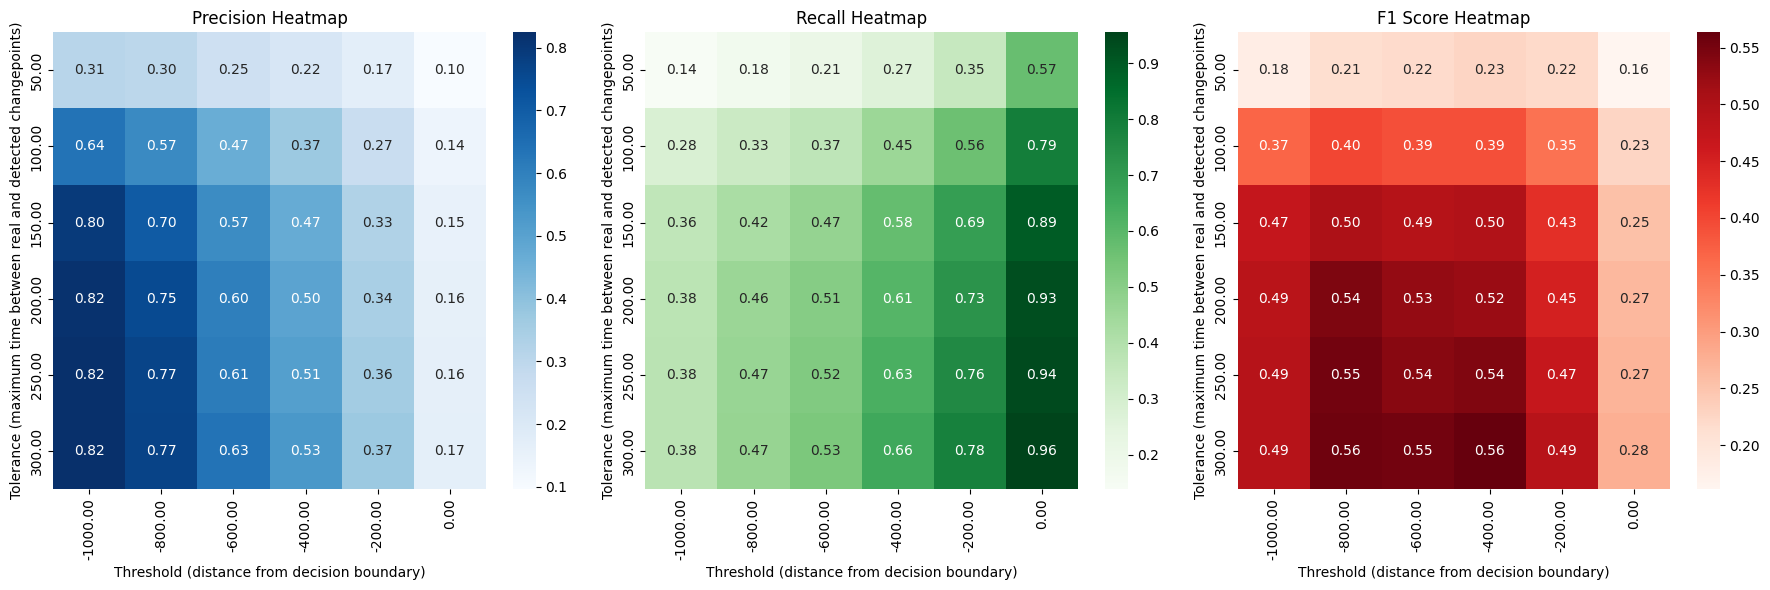

In [9]:
# Define tolerances and thresholds
tolerances = np.arange(50, 301, 50)  # Tolerance values to test
thresholds = np.arange(-1000, 1, 200)  # Threshold values to test

# Initialize result matrices
precision_matrix = np.zeros((len(tolerances), len(thresholds)))
recall_matrix = np.zeros((len(tolerances), len(thresholds)))
f1_matrix = np.zeros((len(tolerances), len(thresholds)))


for t_idx, tolerance in enumerate(tolerances):
    for th_idx, threshold in enumerate(thresholds): 
        # Generate alarms for the current run, threshold, and tolerance
        ocsvm_alarms_run = trigger_ocsvm_alarms_dataset(ocsvm_scores, threshold=threshold)
        # Compute precision, recall, and F1-score for the current configuration
        total_precision, total_recall, total_f1_score = compute_total_precision_recall_f1(
            real_changepoints, ocsvm_alarms_run, tolerance=tolerance
        )
        
        # Accumulate results across runs (mean metrics over runs)
        precision_matrix[t_idx, th_idx] += total_precision
        recall_matrix[t_idx, th_idx] += total_recall
        f1_matrix[t_idx, th_idx] += total_f1_score

def generate_heatmap(precision_grid, recall_grid, f1_score_grid, tolerances, thresholds):
    # Format thresholds and tolerances to two decimal places
    thresholds_formatted = [f"{x:.2f}" for x in thresholds]
    tolerances_formatted = [f"{x:.2f}" for x in tolerances]

    # Plot the heatmaps
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    sns.heatmap(
        precision_grid, 
        xticklabels=thresholds_formatted, 
        yticklabels=tolerances_formatted, 
        ax=axs[0], 
        cmap='Blues', 
        annot=True, 
        fmt=".2f"
    )
    axs[0].set_title("Precision Heatmap")
    axs[0].set_xlabel("Threshold (distance from decision boundary)")
    axs[0].set_ylabel("Tolerance (maximum time between real and detected changepoints)")

    sns.heatmap(
        recall_grid, 
        xticklabels=thresholds_formatted, 
        yticklabels=tolerances_formatted, 
        ax=axs[1], 
        cmap='Greens', 
        annot=True, 
        fmt=".2f"
    )
    axs[1].set_title("Recall Heatmap")
    axs[1].set_xlabel("Threshold (distance from decision boundary)")
    axs[1].set_ylabel("Tolerance (maximum time between real and detected changepoints)")

    sns.heatmap(
        f1_score_grid, 
        xticklabels=thresholds_formatted, 
        yticklabels=tolerances_formatted, 
        ax=axs[2], 
        cmap='Reds', 
        annot=True, 
        fmt=".2f"
    )
    axs[2].set_title("F1 Score Heatmap")
    axs[2].set_xlabel("Threshold (distance from decision boundary)")
    axs[2].set_ylabel("Tolerance (maximum time between real and detected changepoints)")

    plt.tight_layout()
    plt.show()

generate_heatmap(precision_matrix, recall_matrix, f1_matrix, tolerances, thresholds)

## Compute performance for Mahalanobis classifier alone

In [10]:
mahalanobis_scores = np.loadtxt(r'/home/mihai/Thesis/MD_distances_per_run.csv', delimiter=',')

In [11]:
def detect_distractions_mahalanobis_ewma_windowed(
        distances_distracted, 
        chi_squared_limit=0.8, 
        mean_not_distracted_shape=2, 
        decay_factor=0.95, 
        window_size=20):
    """
    Detect distractions using an exponentially weighted moving average (EWMA) 
    of evidence based on Mahalanobis distances, restricted to a sliding window.
    
    Parameters:
        distances_distracted (array-like): Mahalanobis distances over time.
        chi_squared_limit (float): Chi-squared limit for distraction threshold.
        mean_not_distracted_shape (int): Degrees of freedom for chi-squared distribution.
        decay_factor (float): Decay factor for exponential weighting (0 < decay_factor < 1).
        window_size (int): Size of the sliding window.
        
    Returns:
        evidence_function (list): Evidence function over time.
    """
    # Threshold for distraction based on the chi-squared distribution
    threshold_distracted = chi2.ppf(chi_squared_limit, mean_not_distracted_shape)
    
    # Initialize evidence function
    evidence_function = []
    num_samples = len(distances_distracted)

    # Iterate through the data using a sliding window
    for i in range(num_samples):
        # Define the current window
        window_start = max(0, i - window_size + 1)  # Ensure the window does not go negative
        window_end = i + 1  # Inclusive of the current point
        window = distances_distracted[window_start:window_end]
        
        # Compute EWMA within the current window
        evidence = 0  # Reset evidence for the window
        for distance in window:
            if distance > threshold_distracted:
                evidence = decay_factor * evidence + (1 - decay_factor) * (distance - threshold_distracted)
            else:
                evidence = decay_factor * evidence  # Decay evidence when no distraction
        
        # Append the evidence value for the current point
        evidence_function.append(evidence)
    
    return np.array(evidence_function)


def detect_distractions_mahalanobis_cusum(distances_distracted, chi_squared_limit=0.8, mean_not_distracted_shape=2, evidence_threshold=1.5):
    threshold_distracted = chi2.ppf(chi_squared_limit, mean_not_distracted_shape)  # Threshold for distraction
    threshold_reset = chi2.ppf(chi_squared_limit-0.1, mean_not_distracted_shape)      # Threshold to resume search
    
    # Initialize variables for CUSUM
    S_pos = 0  # Positive cumulative sum (for upward shifts, i.e., distraction)
    distractions_detected = []  # List to store timestamps of detected distractions
    distraction_active = False  # Whether distraction detection is currently paused
    S_pos_list = [S_pos]  # List to store the cumulative sum values for visualization
    # Loop through Mahalanobis distances and apply CUSUM logic
    for i, distance_value in enumerate(distances_distracted):
        if distraction_active:
            # If distraction mode is active, wait until the distance falls below the reset threshold
            if distance_value < threshold_reset:
                S_pos = 0  # Reset the cumulative sum after normal behavior
                distraction_active = False  # Resume checking distractions
            continue  # Skip further checks while in distraction mode

        # If the Mahalanobis distance exceeds the distraction threshold, accumulate the difference in S_pos
        if distance_value > threshold_distracted:
            S_pos += distance_value - threshold_distracted
        else:
            S_pos = 0  # Reset S_pos if the distance does not exceed the threshold

        # If S_pos exceeds the threshold h, activate distraction mode
        if S_pos > evidence_threshold:
            distractions_detected.append(i)  # Log the index where distraction is detected
            distraction_active = True  # Activate distraction mode
            S_pos = 0  # Reset cumulative sum to prepare for next detection
        S_pos_list.append(S_pos)
    return distractions_detected, S_pos_list

In [12]:
# first, see how cumsum performs on the data
def md_alarms_dataset(mahalanobis_scores, chi_squared_limit=0.8, mean_not_distracted_shape=2, evidence_threshold=1.5):
    md_alarms = []
    for idx in range(mahalanobis_scores.shape[0]):
        alarms, _ = detect_distractions_mahalanobis_cusum(mahalanobis_scores[idx], chi_squared_limit=chi_squared_limit, mean_not_distracted_shape=mean_not_distracted_shape, evidence_threshold=evidence_threshold)
        md_alarms.append(alarms)
    return md_alarms

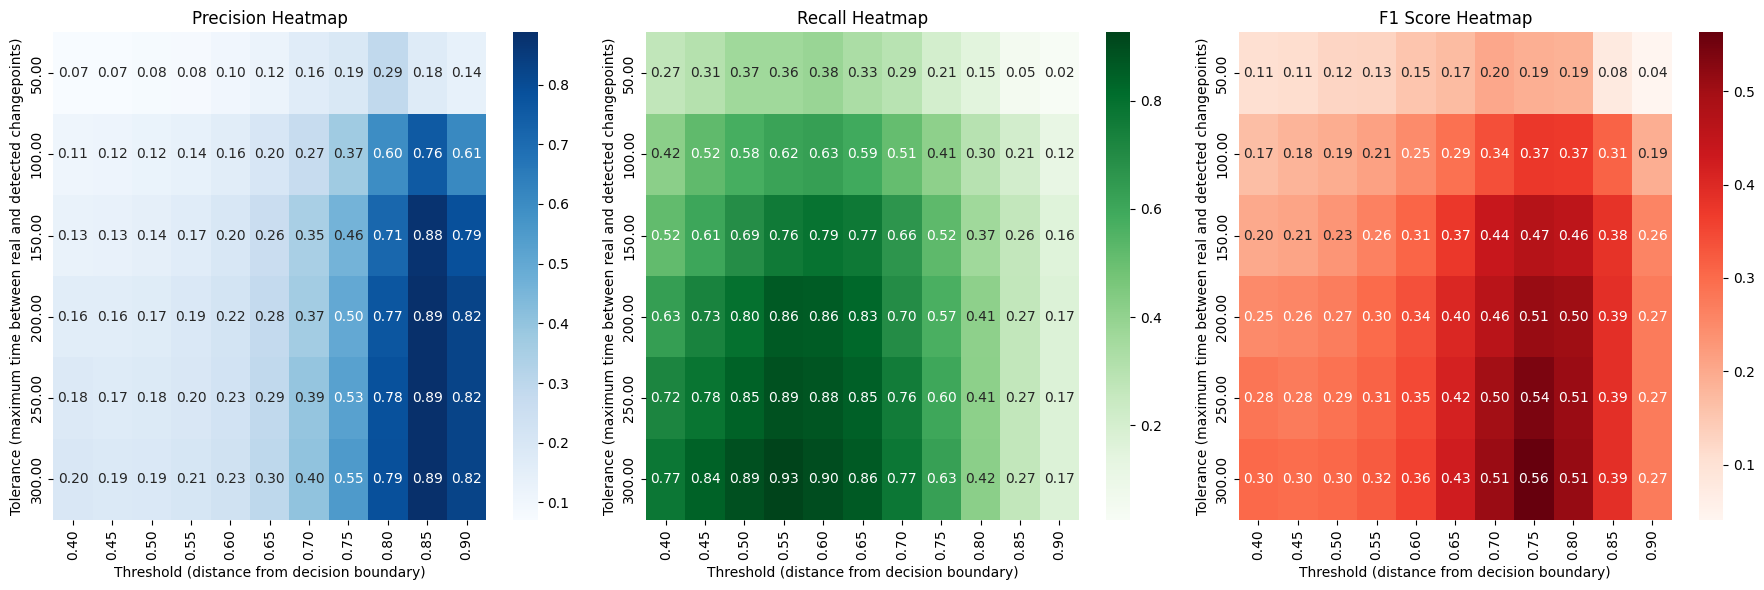

In [13]:
# Define tolerances and thresholds
tolerances = np.arange(50, 301, 50)  # Tolerance values to test
thresholds = np.arange(0.4, 0.905, 0.05)  # Threshold values to test

# Initialize result matrices
precision_matrix = np.zeros((len(tolerances), len(thresholds)))
recall_matrix = np.zeros((len(tolerances), len(thresholds)))
f1_matrix = np.zeros((len(tolerances), len(thresholds)))


for t_idx, tolerance in enumerate(tolerances):
    for th_idx, threshold in enumerate(thresholds): 
        # Generate alarms for the current run, threshold, and tolerance
        md_alarms = md_alarms_dataset(mahalanobis_scores, chi_squared_limit=threshold)
      
        total_precision, total_recall, total_f1_score = compute_total_precision_recall_f1(
            real_changepoints, md_alarms, tolerance=tolerance
        )
        
        # Accumulate results across runs (mean metrics over runs)
        precision_matrix[t_idx, th_idx] += total_precision
        recall_matrix[t_idx, th_idx] += total_recall
        f1_matrix[t_idx, th_idx] += total_f1_score


generate_heatmap(precision_matrix, recall_matrix, f1_matrix, tolerances, thresholds)

In [27]:
# first, see how cumsum performs on the data
def md_alarms_dataset_ewma(mahalanobis_scores, chi_squared_limit=0.7, mean_not_distracted_shape=2, decay_factor=0.95, window_size=20):
    md_evidences = []
    for idx in range(mahalanobis_scores.shape[0]):
        evidence_function = detect_distractions_mahalanobis_ewma_windowed(mahalanobis_scores[idx], chi_squared_limit=chi_squared_limit, mean_not_distracted_shape=mean_not_distracted_shape)
        md_evidences.append(evidence_function)
    return md_evidences

def trigger_md_ewma_alarms(evidence_functions, threshold=1.5):
    md_alarms = []
    for run_idx, evidence_function in enumerate(evidence_functions):
        alarm_indices = trigger_ocsvm_alarm(evidence_function, threshold=threshold)
        md_alarms.append(alarm_indices)
    return md_alarms

md_evidences = md_alarms_dataset_ewma(mahalanobis_scores, chi_squared_limit=0.5, mean_not_distracted_shape=2, decay_factor=0.95, window_size=20)
md_ewma_alarms = trigger_md_ewma_alarms(md_evidences, threshold=1.5) 

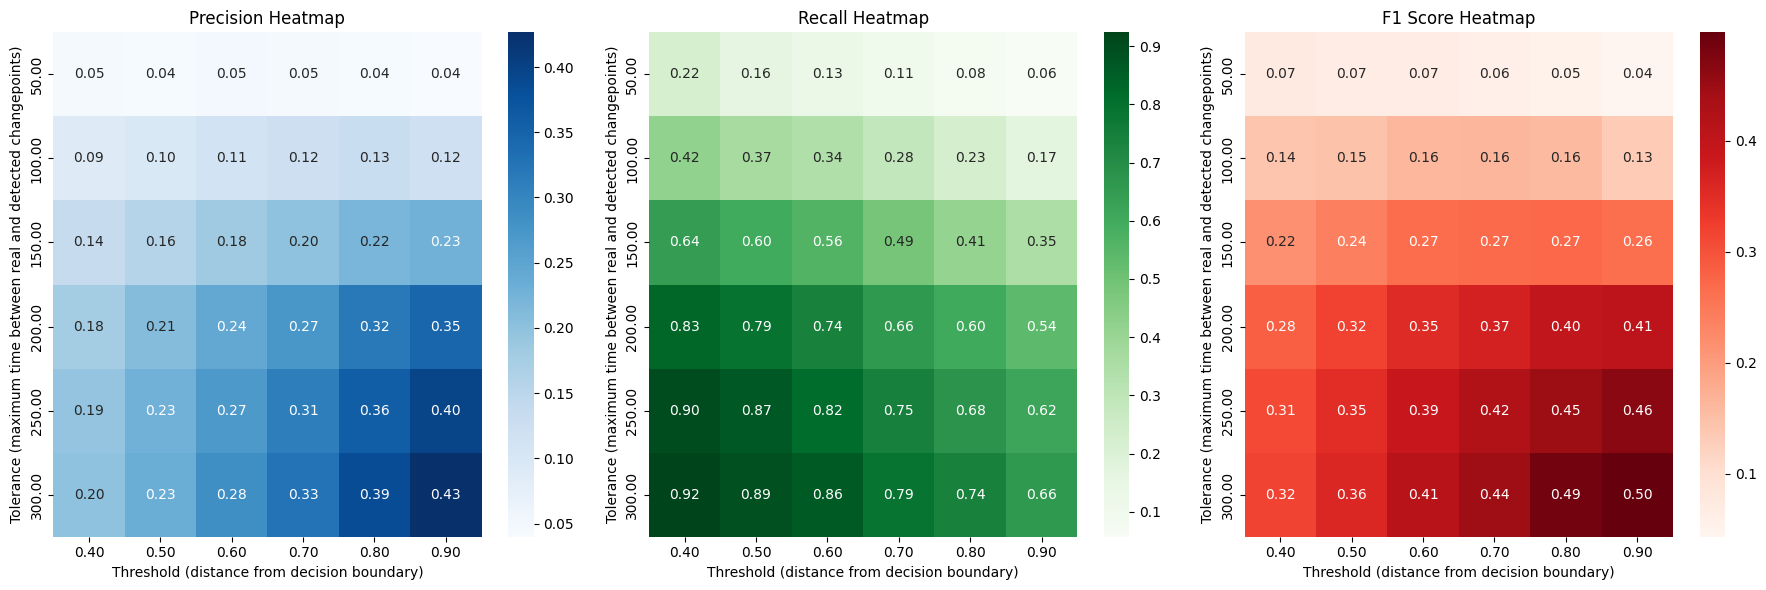

In [29]:
# Define tolerances and thresholds
tolerances = np.arange(50, 301, 50)  # Tolerance values to test
thresholds = np.arange(0.4, 1, 0.1)  # Threshold values to test

# Initialize result matrices
precision_matrix = np.zeros((len(tolerances), len(thresholds)))
recall_matrix = np.zeros((len(tolerances), len(thresholds)))
f1_matrix = np.zeros((len(tolerances), len(thresholds)))


for t_idx, tolerance in enumerate(tolerances):
    for th_idx, threshold in enumerate(thresholds): 
        # Generate alarms for the current run, threshold, and tolerance
        md_ewma_alarms = trigger_md_ewma_alarms(md_evidences, threshold) 
        # Compute precision, recall, and F1-score for the current configuration
        total_precision, total_recall, total_f1_score = compute_total_precision_recall_f1(
            real_changepoints, md_ewma_alarms, tolerance=tolerance
        )
        
        # Accumulate results across runs (mean metrics over runs)
        precision_matrix[t_idx, th_idx] += total_precision
        recall_matrix[t_idx, th_idx] += total_recall
        f1_matrix[t_idx, th_idx] += total_f1_score

generate_heatmap(precision_matrix, recall_matrix, f1_matrix, tolerances, thresholds)